<a href="https://colab.research.google.com/github/greenmetro/FarmHelper/blob/master/plant_disease_dection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "tensorflow_hub>=0.6.0"
!pip install "tensorflow>=2.1.0"

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.8MB 40.7MB/s 
     |████████████████████████████████| 450kB 45.5MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import os 
#Load data
zip_file=tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
 fname='PlantVillage.zip', extract=True)
#Create the training and validation directories
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

856842240/856839084 [==============================] - 17s 0us/step


In [0]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [4]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /root/.keras/datasets/PlantVillage/train : 43444files
total images for validation : /root/.keras/datasets/PlantVillage/validation : 10861files


In [5]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
59c418921242879a6aa5378175076bf7f39a84fe
   creating: Plant-Diseases-Detector-master/
   creating: Plant-Diseases-Detector-master/GreenDoctor/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.gitignore  
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/
   creating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/Project.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/codeStyles/codeStyleConfig.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/encodings.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/gradle.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/misc.xml  
  inflating: Plant-Diseases-Detector-master/GreenDoctor/.idea/runConfigurations.xml  
   creating: Plant-Diseases-Detector-master/GreenDoctor/app/
 extracting: Plant-Diseases-Detector-master/GreenDoctor/app/.gitignore  
  

In [6]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [7]:
print('Number of classes:',len(classes))

Number of classes: 38


In [8]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


In [9]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [0]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [12]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 22,871,366
Trainable params: 1,068,582
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [14]:
EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 678 steps, validate for 169 steps
Epoch 1/5
678/678 [==============================] - 947s 1s/step - loss: 0.7779 - accuracy: 0.7771 - val_loss: 0.4017 - val_accuracy: 0.8767
Epoch 2/5
678/678 [==============================] - 924s 1s/step - loss: 0.4060 - accuracy: 0.8698 - val_loss: 0.3436 - val_accuracy: 0.8906
Epoch 3/5
478/678 [====================>.........] - ETA: 4:20 - loss: 0.3546 - accuracy: 0.8854WARNING:tensorflow:From <ipython-input-14-2ce5b674b8b4>:8: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 678 steps, validate for 169 steps
Epoch 1/5
678/678 [==============================] - 947s 1s/step - loss: 0.7779 - accuracy: 0.7771 - val_loss: 0.4017 - val_accuracy: 0.8767
Epoch 2/5
678/678 [==============================] - 924s 1s/step - loss: 0.4060 - accuracy: 0.8698 - val_loss: 0.3436 - val_accuracy: 0.8906
Epoch 3/5
678/678 [==============================] - 930s 1s/step - loss: 0.3519 - accuracy: 0.8858 - val_loss: 0.3349 - val_accuracy: 0.8876
Epoch 4/5
Epoch 4/5
678/678 [==============================] - 922s 1s/step - loss: 0.3221 - accuracy: 0.8953 - val_loss: 0.2661 - val_accuracy: 0.9150
Epoch 5/5
Epoch 5/5
678/678 [==============================] - 922s 1s/step - loss: 0.2930 - accuracy: 0.9053 - val_loss: 0.2887 - val_accuracy: 0.9048


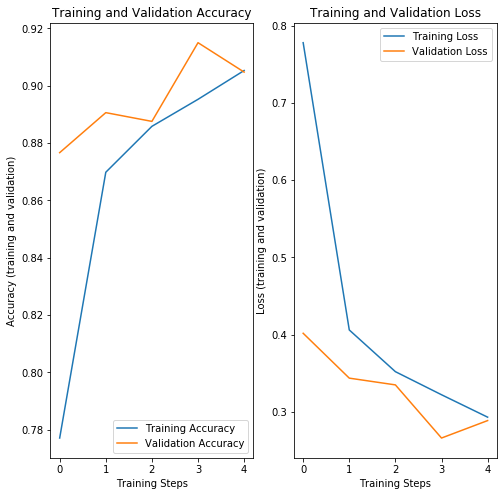

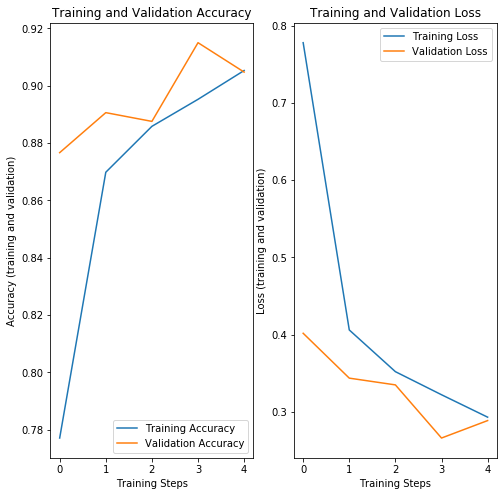

In [15]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [0]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Potato___healthy, file: Potato___healthy/9c620128-2872-4bbb-bc14-d5b785242cf6___RS_HL 1751.JPG
PREDICTED: class: Potato___healthy, confidence: 0.421750
SOURCE: class: Potato___healthy, file: Potato___healthy/9c620128-2872-4bbb-bc14-d5b785242cf6___RS_HL 1751.JPG
PREDICTED: class: Potato___healthy, confidence: 0.421750


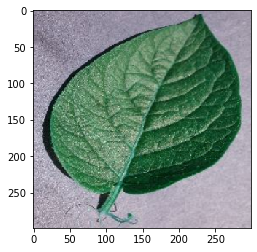

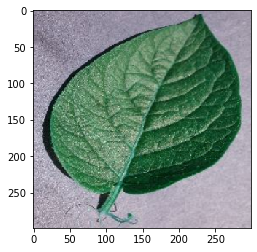

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/b5863c78-1aba-4494-b0eb-e2b37f5f876b___RS_HL 4088.JPG
PREDICTED: class: Soybean___healthy, confidence: 0.981623
SOURCE: class: Soybean___healthy, file: Soybean___healthy/b5863c78-1aba-4494-b0eb-e2b37f5f876b___RS_HL 4088.JPG
PREDICTED: class: Soybean___healthy, confidence: 0.981623


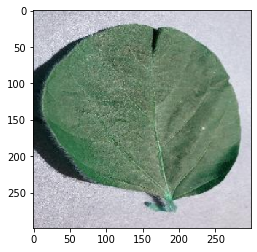

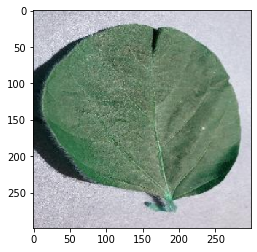

SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/da0ffa44-de62-4314-acb2-59218f5deeb5___GCREC_Bact.Sp 6010.JPG
PREDICTED: class: Tomato___Septoria_leaf_spot, confidence: 0.577683
SOURCE: class: Tomato___Bacterial_spot, file: Tomato___Bacterial_spot/da0ffa44-de62-4314-acb2-59218f5deeb5___GCREC_Bact.Sp 6010.JPG
PREDICTED: class: Tomato___Septoria_leaf_spot, confidence: 0.577683


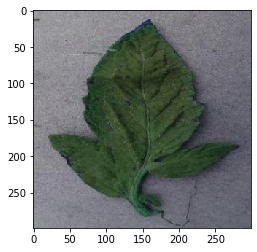

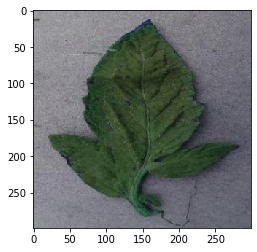

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/3088ab27-1aaa-490f-bc3e-86d24781c93c___CREC_HLB 4843.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.999732
SOURCE: class: Orange___Haunglongbing_(Citrus_greening), file: Orange___Haunglongbing_(Citrus_greening)/3088ab27-1aaa-490f-bc3e-86d24781c93c___CREC_HLB 4843.JPG
PREDICTED: class: Orange___Haunglongbing_(Citrus_greening), confidence: 0.999732


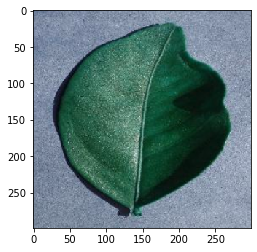

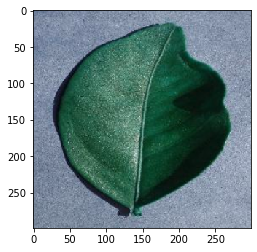

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

SOURCE: class: Pepper,_bell___Bacterial_spot, file: Pepper,_bell___Bacterial_spot/d6a6180b-9e2f-41a1-ac2f-7463a50f59b1___JR_B.Spot 3172.JPG
PREDICTED: class: Pepper,_bell___Bacterial_spot, confidence: 0.748208
SOURCE: class: Pepper,_bell___Bacterial_spot, file: Pepper,_bell___Bacterial_spot/d6a6180b-9e2f-41a1-ac2f-7463a50f59b1___JR_B.Spot 3172.JPG
PREDICTED: class: Pepper,_bell___Bacterial_spot, confidence: 0.748208


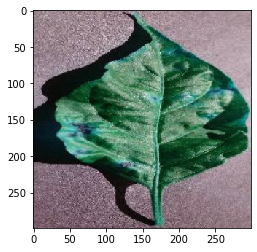

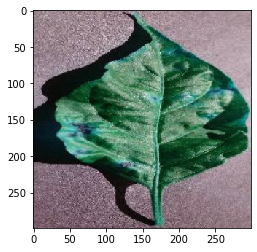

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [17]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [18]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
#tf.keras.experimental.export_saved_model(model, export_path)
model.save(export_path, save_format="tf")

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1583120657/assets
INFO:tensorflow:Assets written to: /tmp/saved_models/1583120657/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1583120657/assets
INFO:tensorflow:Assets written to: /tmp/saved_models/1583120657/assets


'/tmp/saved_models/1583120657'

'/tmp/saved_models/1583120657'

In [0]:
# Now confirm that we can reload it, and it still gives the same results
#reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
reloaded = tf.keras.models.load_model(export_path)

In [0]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Apple___healthy, file: Apple___healthy/3ee70760-b734-43e2-b29b-aee4daafe6cd___RS_HL 7317.JPG
SOURCE: class: Apple___healthy, file: Apple___healthy/3ee70760-b734-43e2-b29b-aee4daafe6cd___RS_HL 7317.JPG
PREDICTED: class: Apple___healthy, confidence: 0.882156
PREDICTED: class: Apple___healthy, confidence: 0.882156


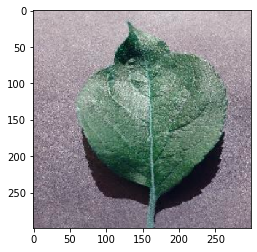

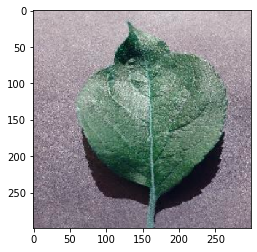

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

SOURCE: class: Strawberry___Leaf_scorch, file: Strawberry___Leaf_scorch/bcf52398-58a1-414e-afd7-ba7b0e26d66e___RS_L.Scorch 1110.JPG
PREDICTED: class: Tomato___Early_blight, confidence: 0.696889
SOURCE: class: Strawberry___Leaf_scorch, file: Strawberry___Leaf_scorch/bcf52398-58a1-414e-afd7-ba7b0e26d66e___RS_L.Scorch 1110.JPG
PREDICTED: class: Tomato___Early_blight, confidence: 0.696889


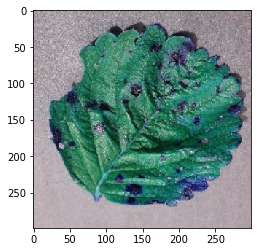

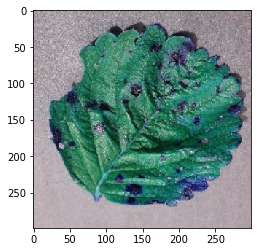

In [21]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [22]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

91445528

91445528